In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from robo_limb_ml.models.fk_lstm import FK_LSTM
from robo_limb_ml.models.fk_mlp import FK_MLP
from robo_limb_ml.models.fk_rnn import FK_RNN
from robo_limb_ml.models.fk_seq2seq import FK_SEQ2SEQ
from robo_limb_ml.utils.utils import rollout
from tqdm import tqdm



In [2]:
def viz_graph(outputs_df, test_df, run_name, display_window=1500):
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs[0, 0].plot(test_df["time_begin"][:display_window], test_df["theta_x"][:display_window], label="Actual")
    axs[0, 0].plot(outputs_df["time_begin"][:display_window], outputs_df["theta_x"][:display_window], label="Predicted")
    axs[0, 0].set_title("Theta X")
    axs[0, 0].legend()
    axs[0, 1].plot(test_df["time_begin"][:display_window], test_df["theta_y"][:display_window], label="Actual")
    axs[0, 1].plot(outputs_df["time_begin"][:display_window], outputs_df["theta_y"][:display_window], label="Predicted")
    axs[0, 1].set_title("Theta Y")
    axs[0, 1].legend()
    axs[1, 0].plot(test_df["time_begin"][:display_window], test_df["vel_x"][:display_window], label="Actual")
    axs[1, 0].plot(outputs_df["time_begin"][:display_window], outputs_df["vel_x"][:display_window], label="Predicted")
    axs[1, 0].set_title("Vel X")
    axs[1, 0].legend()
    axs[1, 1].plot(test_df["time_begin"][:display_window], test_df["vel_y"][:display_window], label="Actual")
    axs[1, 1].plot(outputs_df["time_begin"][:display_window], outputs_df["vel_y"][:display_window], label="Predicted")
    axs[1, 1].legend()
    axs[1, 1].set_title("Vel Y")
    fig.suptitle(run_name, fontsize=16)
    return fig

  0%|          | 0/54 [00:00<?, ?it/s]/home/ubuntu/Research-HW/SML/RobLimbFK/robo_limb_ml/utils/utils.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_

device of SEQ2SEQ_Encoder cuda
device of SEQ2SEQ_decoder cuda
device of SEQ2SEQ cuda


100%|██████████| 31216/31216 [01:11<00:00, 433.67it/s]


R^2 0.8484681844711304
RMSE 9.73501968383789


 94%|█████████▍| 51/54 [01:12<00:04,  1.42s/it]/home/ubuntu/Research-HW/SML/RobLimbFK/robo_limb_ml/utils/utils.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.lo

device of SEQ2SEQ_Encoder cuda
device of SEQ2SEQ_decoder cuda
device of SEQ2SEQ cuda


100%|██████████| 31216/31216 [01:10<00:00, 444.01it/s]


R^2 0.8745964765548706
RMSE 8.598742485046387


 96%|█████████▋| 52/54 [02:23<00:06,  3.32s/it]/home/ubuntu/Research-HW/SML/RobLimbFK/robo_limb_ml/utils/utils.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.loa

device of LSTM cuda


100%|██████████| 31216/31216 [01:07<00:00, 459.30it/s]


R^2 0.8463760614395142
RMSE 9.79986572265625


100%|██████████| 54/54 [03:32<00:00,  3.93s/it]


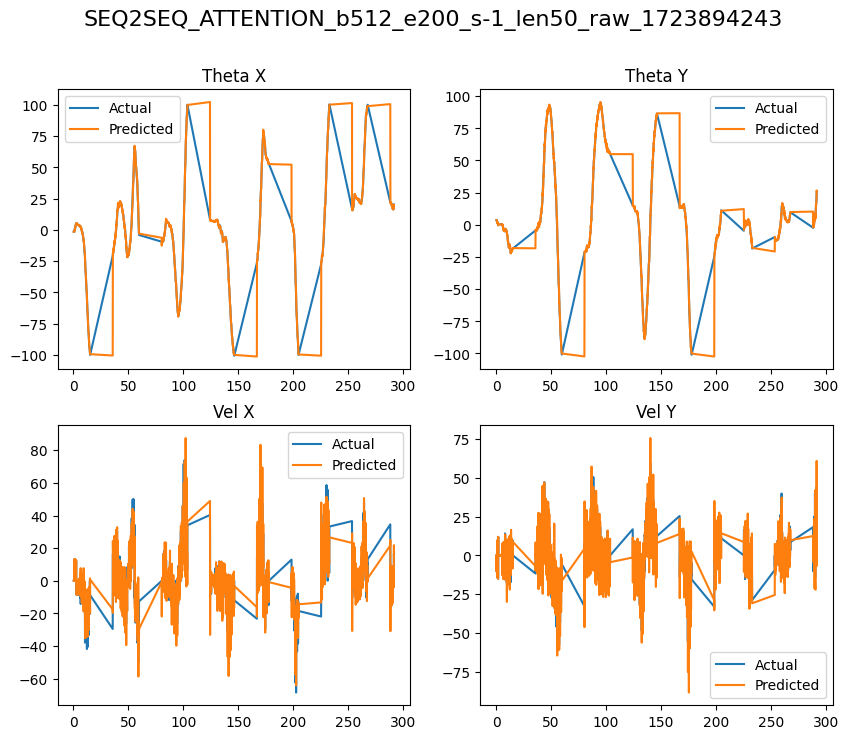

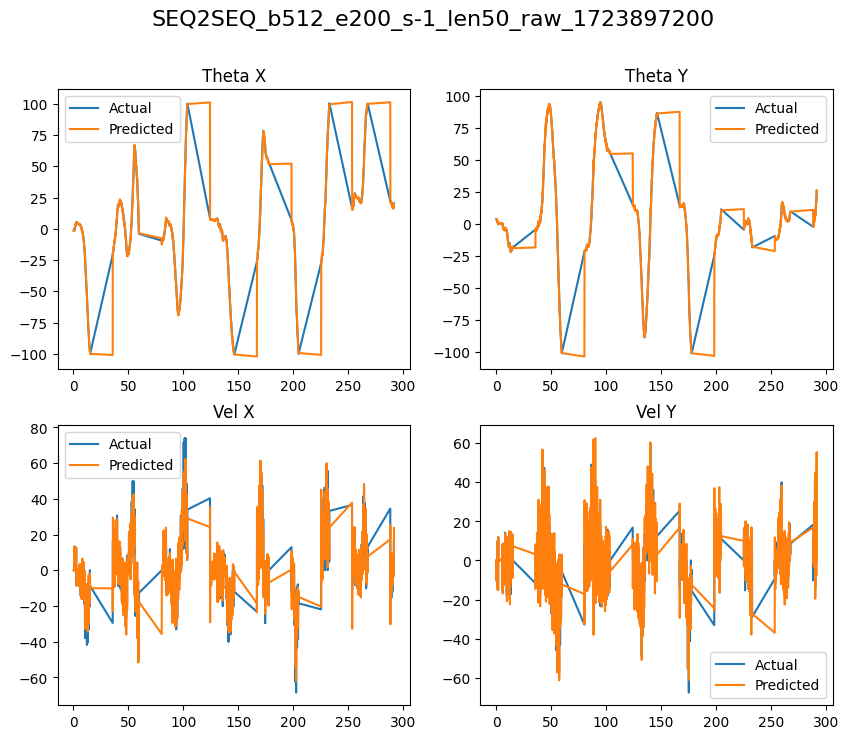

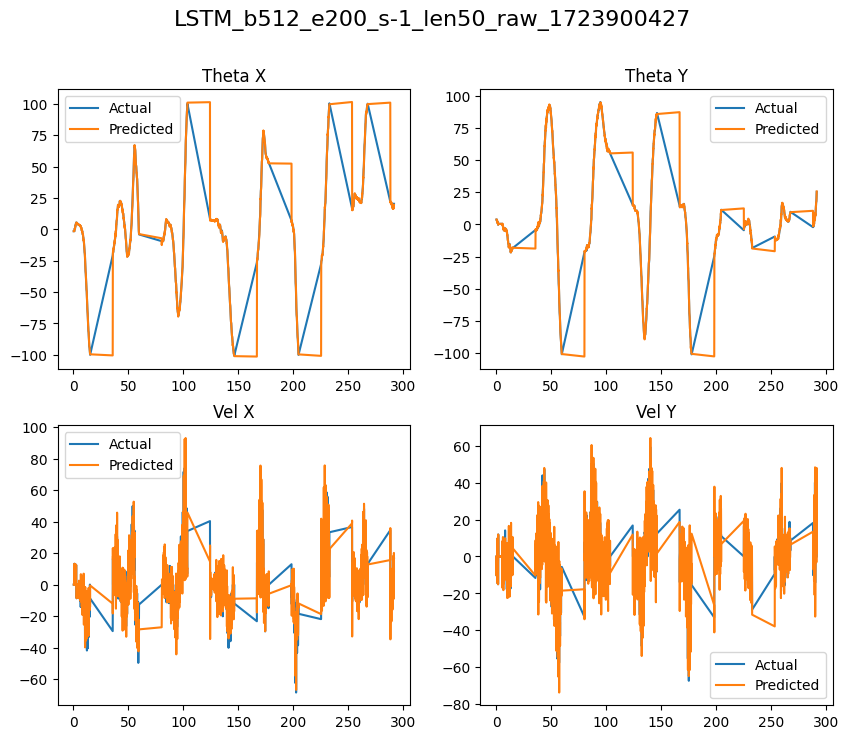

In [3]:
input_size = 6
hidden_size = 512
num_layers = 3
batch_size = 512
output_size = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

files = os.listdir('../../model_weights/new_weights')

for file in tqdm(files):
    file_lower = file.lower()
    # skip RNN and MLP
    if 'rnn' in file_lower or 'mlp' in file_lower:
        continue
    # if 'vel' not in file_lower and 'no_time' not in file_lower:
    #     continue
    if 'raw' not in file_lower:
        continue
    
    if 'vel' in file_lower:
        input_size = 8
    elif 'raw' in file_lower:
        input_size = 4
    else:
        input_size = 6
    
    if 'finetune' in file_lower:
        test_data_path = '../../ml_data/purple_test_data.csv'
    elif 'cool' in file_lower:
        test_data_path = '../../ml_data/purple_no_cool_down_test_data.csv'
    else:
        test_data_path = '../../ml_data/test_data.csv'
    filename = '../../model_weights/new_weights/' + file
    outputs_df, test_df, r2_score, rmse = rollout(filename,
                                                  test_data_path,
                                                  input_size,
                                                  hidden_size,
                                                  num_layers,
                                                  batch_size,
                                                  output_size,
                                                  device)
    fig = viz_graph(outputs_df, test_df, file)
    
    with open("../../results/"+file+".txt", 'w') as f:
        f.write("RMSE: " + str(rmse) + '\n')
        f.write("R^2: " + str(r2_score))
    
    fig.savefig("../../results/"+file+".jpg")
    fig.show()

/home/ubuntu/Research-HW/SML/RobLimbFK/robo_limb_ml/utils/utils.py:100: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_locati

device of SEQ2SEQ_Encoder cuda
device of SEQ2SEQ_decoder cuda
device of SEQ2SEQ cuda


100%|██████████| 31243/31243 [03:53<00:00, 134.05it/s]


R^2 0.8221787214279175
RMSE 7.2825541496276855
tensor(7.2826, device='cuda:0')
tensor(0.8222, device='cuda:0')


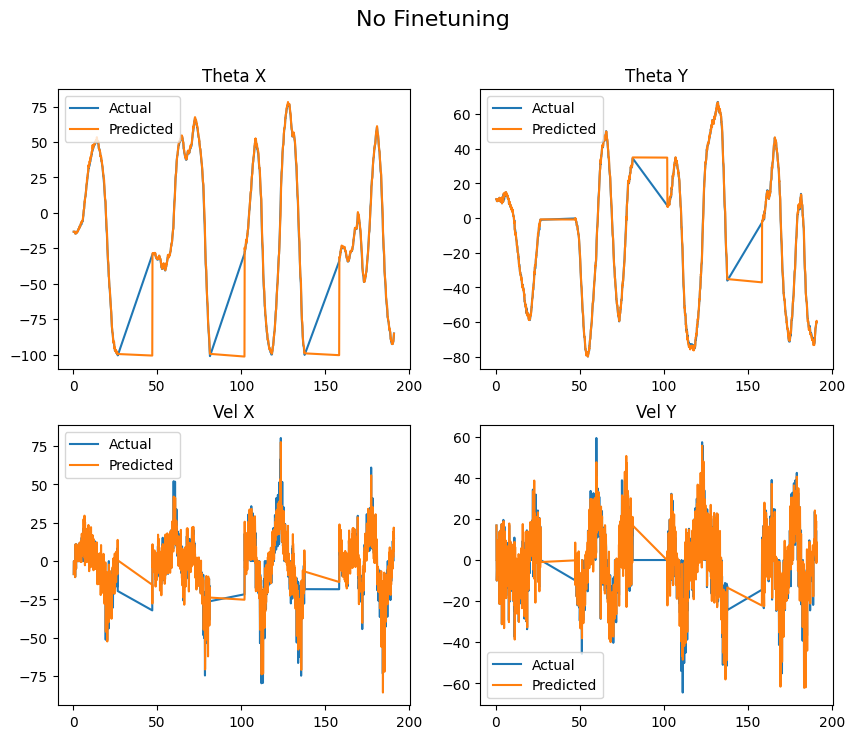

In [4]:
outputs_df, test_df, r2_score, rmse = rollout('../../model_weights/new_weights/SEQ2SEQ_ATTENTION_b512_e200_s-1_Seq2Seq_len50_LSTM_1722928107',
                                              '../../ml_data/purple_test_data.csv',
                                                  input_size,
                                                  hidden_size,
                                                  num_layers,
                                                  batch_size,
                                                  output_size,
                                                  device)
fig = viz_graph(outputs_df, test_df, 'No Finetuning')
print(rmse)
print(r2_score)
fig.show()

In [3]:
input_size = 6
hidden_size = 512
num_layers = 3
batch_size = 512
output_size = 4
seq_len = 50
stateful = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model_path = "/home/ubuntu/Research-HW/SML/RobLimbFK/robo_limb_ml/model_weights/new_weights/LSTM_b512_e200_s-1_LSTM_len10_1722940896"
model_path = "../../model_weights/new_weights/SEQ2SEQ_ATTENTION_b512_e200_s-1_Seq2Seq_len50_LSTM_1722928107"
# model = FK_LSTM(input_size=input_size,
#                 hidden_size=hidden_size,
#                 num_layers=num_layers,
#                 batch_size=batch_size,
#                 output_size=output_size,
#                 device=device,
#                 batch_first=True).to(device=device)
# model.load_state_dict(torch.load(model_path, map_location=device))
# model.h0 = torch.zeros(num_layers, 1, hidden_size).to(device=device)
# model.c0 = torch.zeros(num_layers, 1, hidden_size).to(device=device)
model = FK_SEQ2SEQ(input_size=input_size,
                   embedding_size=hidden_size,
                   num_layers=num_layers,
                   batch_size=batch_size,
                   output_size=output_size,
                   device=device,
                   batch_first=True,
                   encoder_type='LSTM',
                   decoder_type='LSTM',
                   attention=True,
                   pred_len=1,
                   teacher_forcing_ratio=0.0).to(device=device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

device of SEQ2SEQ_Encoder cuda
device of SEQ2SEQ_decoder cuda
device of SEQ2SEQ cuda


/tmp/ipykernel_28833/3874726888.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


FK_SEQ2SEQ(
  (encoder): SEQ2SEQ_Encoder(
    (encoder): LSTM(6, 512, num_layers=3, batch_first=True)
  )
  (decoder): SEQ2SEQ_Decoder(
    (decoder): LSTM(6, 512, num_layers=3, batch_first=True)
    (fc): Linear(in_features=512, out_features=4, bias=True)
    (attention_layer): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
    )
    (fc1): Linear(in_features=6, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=6, bias=True)
  )
  (activation): Tanh()
)

In [4]:
test_df = pd.read_csv("../../ml_data/test_data.csv").dropna()
test_df


,time_begin,time_begin_traj,theta_x,theta_y,vel_x,vel_y,X_throttle,Y_throttle
0,0.348,0.348,-1.50,3.70,0.0,0.000000,0.0,0.0
1,0.409,0.409,-1.50,3.07,0.0,-10.327869,0.0,0.0
2,0.471,0.471,-1.50,3.07,0.0,0.000000,0.0,0.0
3,0.532,0.532,-1.50,3.07,0.0,0.000000,0.0,0.0
4,0.594,0.594,-1.50,3.07,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...
31261,1172.517,121.126,-22.03,-37.59,0.0,0.000000,-2.0,10.0
31262,1172.589,121.198,-22.03,-37.59,0.0,0.000000,-2.0,10.0
31263,1172.661,121.270,-22.03,-37.06,0.0,7.361111,-2.0,10.0
31264,1172.733,121.342,-22.03,-37.06,0.0,0.000000,-2.0,10.0


In [5]:
# test_df = test_df[['time_begin', 'time_begin_traj', 'theta_x', 'theta_y',
#        'X_throttle', 'Y_throttle' , 'vel_x', 'vel_y']]
# test_df = test_df.reindex(columns=['time_begin', 'time_begin_traj', 'theta_x', 'theta_y',
#        'X_throttle', 'Y_throttle' , 'vel_x', 'vel_y'], copy=False)
col_1 = test_df.pop('vel_x')
test_df.insert(7, col_1.name, col_1)
col_2 = test_df.pop('vel_y')
test_df.insert(7, col_2.name, col_2)
test_df

,time_begin,time_begin_traj,theta_x,theta_y,X_throttle,Y_throttle,vel_x,vel_y
0,0.348,0.348,-1.50,3.70,0.0,0.0,0.0,0.000000
1,0.409,0.409,-1.50,3.07,0.0,0.0,0.0,-10.327869
2,0.471,0.471,-1.50,3.07,0.0,0.0,0.0,0.000000
3,0.532,0.532,-1.50,3.07,0.0,0.0,0.0,0.000000
4,0.594,0.594,-1.50,3.07,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
31261,1172.517,121.126,-22.03,-37.59,-2.0,10.0,0.0,0.000000
31262,1172.589,121.198,-22.03,-37.59,-2.0,10.0,0.0,0.000000
31263,1172.661,121.270,-22.03,-37.06,-2.0,10.0,0.0,7.361111
31264,1172.733,121.342,-22.03,-37.06,-2.0,10.0,0.0,0.000000


In [ ]:
from tqdm import tqdm
test_tensor = torch.tensor(test_df.values.copy(), dtype=torch.float32).to(device=device)
# obs_tensor = torch.tensor(test_df.drop(columns=["vel_x", "vel_y"]).values, dtype=torch.float32).to(device=device)
outputs = torch.zeros(test_df.shape).to(device=device)
outputs[:seq_len] = test_tensor[:seq_len].clone()
hn = torch.zeros(3, 1, 512).to(device=device)
cn = torch.zeros(3, 1, 512).to(device=device)
hidden = (hn, cn)
with torch.no_grad():
    for i in tqdm(range(seq_len, test_df.shape[0])):
        data = outputs[i - seq_len:i, :-2]
        time_begin, time_begin_traj, theta_x, theta_y, X_throttle, Y_throttle, vel_x, vel_y  = test_tensor[i - 1]
        if stateful:
            # delta_states, hn, cn = model(data.unsqueeze(0), hn, cn) LSTM
            delta_states, hidden = model(data.unsqueeze(0), None, hidden, mode='test')
        else:
            delta_states, _ = model(data.unsqueeze(0), None, hidden, mode='test')
        delta_states = delta_states.squeeze()
        time_begin_1, time_begin_traj_1, _, _, X_throttle_1, Y_throttle_1, _, _ = test_tensor[i]
        pred_theta_x, pred_theta_y, pred_vel_x, pred_vel_y = delta_states[0] + theta_x, delta_states[1] + theta_y, delta_states[2] + vel_x, delta_states[3] + vel_y
        outputs[i] = torch.tensor([time_begin_1, time_begin_traj_1, pred_theta_x, pred_theta_y, X_throttle_1, Y_throttle_1, pred_vel_x, pred_vel_y]).to(device=device)

In [23]:
outputs_df = pd.DataFrame(outputs.cpu().detach().numpy(), columns=test_df.columns)
output_states = torch.tensor(outputs_df[['theta_x', 'theta_y', 'vel_x', 'vel_y']].values, dtype=torch.float32).to(device=device)
test_states = torch.tensor(test_df[['theta_x', 'theta_y', 'vel_x', 'vel_y']].values, dtype=torch.float32).to(device=device)
from torcheval.metrics import R2Score
metric = R2Score()
metric.update(test_states, output_states)
r2_score = metric.compute()
print("R^2", r2_score.item())

rmse = torch.sqrt(nn.MSELoss()(test_states, output_states))
print("RMSE", rmse.item())

R^2 0.868349015712738
RMSE 8.600626945495605


In [21]:
outputs_df = pd.DataFrame(outputs.cpu().detach().numpy(), columns=test_df.columns)

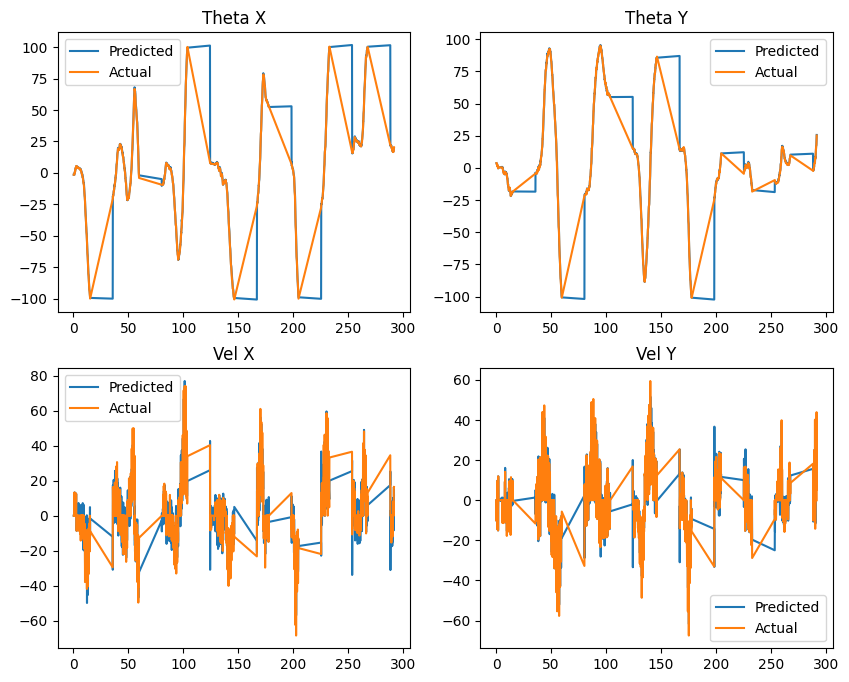

In [22]:
display_window = 1500
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs[0, 0].plot(outputs_df["time_begin"][:display_window], outputs_df["theta_x"][:display_window], label="Predicted")
axs[0, 0].plot(test_df["time_begin"][:display_window], test_df["theta_x"][:display_window], label="Actual")
axs[0, 0].set_title("Theta X")
axs[0, 0].legend()
axs[0, 1].plot(outputs_df["time_begin"][:display_window], outputs_df["theta_y"][:display_window], label="Predicted")
axs[0, 1].plot(test_df["time_begin"][:display_window], test_df["theta_y"][:display_window], label="Actual")
axs[0, 1].set_title("Theta Y")
axs[0, 1].legend()
axs[1, 0].plot(outputs_df["time_begin"][:display_window], outputs_df["vel_x"][:display_window], label="Predicted")
axs[1, 0].plot(test_df["time_begin"][:display_window], test_df["vel_x"][:display_window], label="Actual")
axs[1, 0].set_title("Vel X")
axs[1, 0].legend()
axs[1, 1].plot(outputs_df["time_begin"][:display_window], outputs_df["vel_y"][:display_window], label="Predicted")
axs[1, 1].plot(test_df["time_begin"][:display_window], test_df["vel_y"][:display_window], label="Actual")
axs[1, 1].legend()
axs[1, 1].set_title("Vel Y")
fig.show()

In [15]:
results_output_dir = "../../results/oct_27/outputs"
results_gnd_truth_dir = "../../results/oct_27/test"
output_files_list = os.listdir(results_output_dir)

models = []
rmse_vels = []
rmse_thetas = []
rmse_theta_xs = []
rmse_theta_ys = []

for output_file in output_files_list:
    if 'no_fine_tun' not in output_file:
        continue
    output_file_path = os.path.join(results_output_dir, output_file)
    output_df = pd.read_csv(output_file_path, index_col=0).iloc[:]
    model_name = "_".join(output_file.split("_")[1:])
    gnd_truth_file = "test_" + model_name
    gnd_truth_file_path = os.path.join(results_gnd_truth_dir, gnd_truth_file)
    gnd_truth_df = pd.read_csv(gnd_truth_file_path, index_col=0)[:]
    
    gnd_truth_vel_values = gnd_truth_df[["vel_x", "vel_y"]].values
    output_vel_values = output_df[["vel_x", "vel_y"]].values
    
    gnd_truth_theta_values = gnd_truth_df[["theta_x", "theta_y"]].values
    output_theta_values = output_df[["theta_x", "theta_y"]].values
    
    gnd_truth_theta_x_values = gnd_truth_df[["theta_x"]].values
    output_theta_x_values = output_df[["theta_x"]].values
    
    gnd_truth_theta_y_values = gnd_truth_df[["theta_y"]].values
    output_theta_y_values = output_df[["theta_y"]].values
    
    rmse_vel = np.sqrt(np.mean((gnd_truth_vel_values - output_vel_values) ** 2))
    rmse_theta = np.sqrt(np.mean((gnd_truth_theta_values - output_theta_values) ** 2))
    rmse_theta_x = np.sqrt(np.mean((gnd_truth_theta_x_values - output_theta_x_values) ** 2))
    rmse_theta_y = np.sqrt(np.mean((gnd_truth_theta_y_values - output_theta_y_values) ** 2))
    
    models.append(model_name)
    rmse_vels.append(rmse_vel)
    rmse_thetas.append(rmse_theta)
    rmse_theta_xs.append(rmse_theta_x)
    rmse_theta_ys.append(rmse_theta_y)

model_rmse_df = pd.DataFrame({"Model": models,
                              "RMSE Velocities": rmse_vels,
                              "RMSE Thetas": rmse_thetas,
                              "RMSE Theta x": rmse_theta_xs,
                              "RMSE Theta y": rmse_theta_ys})
    
    

In [16]:
rmse_sorted = model_rmse_df.sort_values(by="RMSE Thetas", ascending=True)


In [17]:
rmse_sorted

,Model,RMSE Velocities,RMSE Thetas,RMSE Theta x,RMSE Theta y
4,FINETUNE_SEQ2SEQ_ATTENTION_b1024_e400_s25000_f...,9.155067,0.643248,0.361349,0.834843
5,SEQ2SEQ_ATTENTION_b1024_e400_s25000_len100_250...,9.407090,0.667025,0.424724,0.842291
3,SEQ2SEQ_ATTENTION_b1024_e400_s-1_len100_ema_0....,11.949504,0.839165,0.400244,1.117229
2,FINETUNE_SEQ2SEQ_ATTENTION_b1024_e400_s25000_f...,7.860341,23.007615,22.664459,23.345728
1,SEQ2SEQ_ATTENTION_b1024_e400_s25000_len100_250...,7.771471,28.108864,28.768911,27.432940
0,SEQ2SEQ_ATTENTION_b1024_e400_s-1_len100_ema_0....,9.375079,29.187446,27.708591,30.594902


In [14]:
rmse_sorted[rmse_sorted["Model"].str.contains("e400_s-1_len100_ema_0.8")]

,Model,RMSE Velocities,RMSE Thetas,RMSE Theta x,RMSE Theta y
3,SEQ2SEQ_ATTENTION_b1024_e400_s-1_len100_ema_0....,11.879440,0.865211,0.375041,1.164699
0,SEQ2SEQ_ATTENTION_b1024_e400_s-1_len100_ema_0....,9.029381,28.580054,28.840218,28.317500


In [5]:
results_dir = "../../results/oct_4"
for model in model_rmse_df["Model"]:
    result_file = model[:-4] + ".txt"
    with open(os.path.join(results_dir, result_file), 'a') as f:
        f.write("\nRMSE Velocities: " + str(model_rmse_df[model_rmse_df["Model"] == model]["RMSE Velocities"].values[0]) + '\n')
        f.write("RMSE Thetas: " + str(model_rmse_df[model_rmse_df["Model"] == model]["RMSE Thetas"].values[0]) + '\n')
        f.write("\nRMSE Theta x: " + str(model_rmse_df[model_rmse_df["Model"] == model]["RMSE Theta x"].values[0]) + '\n')
        f.write("RMSE Theta y: " + str(model_rmse_df[model_rmse_df["Model"] == model]["RMSE Theta y"].values[0]) + '\n')